<a href="https://colab.research.google.com/github/imtiaz114/Brain_tumor_detection_from_2D_MRI_images/blob/main/Brain_tumor_detection_CNN_architecutre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Baseline

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import tensorflow_datasets as tfds

import shutil, random, os,glob
import cv2
import tempfile

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
BATCH_SIZE = 16
IMG_SIZE = (128,128)
INITIAL_EPOCHS = 200
LR = 0.001

## Prepare the dataset

In [3]:
#counting files
os.chdir('/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/non_tumor/')
count = 0
for f in glob.glob("*"):
  count += 1

print(count)

20


In [4]:
x_train = np.zeros(((202,IMG_SIZE[0],IMG_SIZE[1],3)))
x_test  = np.zeros(((51,IMG_SIZE[0],IMG_SIZE[1],3)))
y_train = np.zeros(202,dtype = np.uint8)
y_test  = np.zeros(51,dtype = np.uint8)

In [5]:
#train yes
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/train/tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  img = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
  x_train[count,:,:,:]  = img
  y_train[count] = 1
  #print(count)
  count += 1

In [6]:
#train no
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/train/non_tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  img = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
  x_train[count,:,:,:]  = img
  y_train[count] = 0
  #print(count)
  count += 1

In [7]:
#test yes
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  img = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
  x_test[count,:,:,:]  = img
  y_test[count] = 1
  #print(count)
  count += 1

In [8]:
#test no
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/non_tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  img = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
  x_test[count,:,:,:]  = img
  y_test[count] = 0
  #print(count)
  count += 1

In [9]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(202, 128, 128, 3) (202,) (51, 128, 128, 3) (51,)


### verifying

In [10]:
print(np.sum(y_train == 0),np.sum(y_test == 0))
print(np.sum(y_train == 1),np.sum(y_test == 1))

78 20
124 31


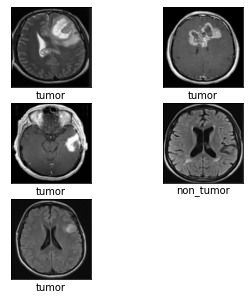

In [11]:
class_names = ['non_tumor','tumor']

plt.figure(figsize=(5,5))

idx = np.random.randint(0,175,5)
i = 0
for i in range(len(idx)):
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[int(idx[i])])
    #print(y_train[idx[i]])
    plt.xlabel(class_names[y_train[idx[i]]])
    i += 1
plt.show()

## Defining the model

In [12]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = models.Sequential()
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid',bias_initializer=output_bias))

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR, beta_1=0.9,beta_2=0.999, epsilon=None,amsgrad=False),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

  return model

## Training the model

In [14]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [16]:
history = model.fit(x_train,y_train, epochs=INITIAL_EPOCHS,steps_per_epoch=13, batch_size= BATCH_SIZE,callbacks=[early_stopping])

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


13/13 [==============================] - 45s 53ms/step - loss: 0.9974 - accuracy: 0.5896 - precision: 0.6162 - recall: 0.8394
Epoch 2/200
13/13 [==============================] - 0s 24ms/step - loss: 0.5105 - accuracy: 0.6960 - precision: 0.7172 - recall: 0.8364
Epoch 3/200
13/13 [==============================] - 0s 24ms/step - loss: 0.4255 - accuracy: 0.7445 - precision: 0.7522 - recall: 0.8724
Epoch 4/200
13/13 [==============================] - 0s 24ms/step - loss: 0.2678 - accuracy: 0.7773 - precision: 0.7788 - recall: 0.8895
Epoch 5/200
13/13 [==============================] - 0s 24ms/step - loss: 0.1636 - accuracy: 0.8073 - precision: 0.8056 - recall: 0.9039
Epoch 6/200
13/13 [==============================] - 0s 23ms/step - loss: 0.0850 - accuracy: 0.8365 - precision: 0.8319 - recall: 0.9187
Epoch 7/200
13/13 [==============================] - 0s 24ms/step - loss: 0.0563 - accuracy: 0.8581 - precision: 0.8534 - recall: 0.9287
Epoch 8/200
13/13 [==============================] -

In [17]:
# Save the weights
#model.save_weights('/content/drive/MyDrive/Dataset_2/final_dataset/weights/dataset1_baseline')

## Evaluate the model

In [18]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(x_test,y_test, verbose=2)
print('Accuracy : ' + str(test_acc))
print('Loss : ' + str(test_loss))
print('Precision : ' + str(test_precision))
print('Recall : ' + str(test_recall))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


2/2 - 1s - loss: 0.7439 - accuracy: 0.9954 - precision: 0.9948 - recall: 0.9977
Accuracy : 0.9954131245613098
Loss : 0.7439443469047546
Precision : 0.9948399066925049
Recall : 0.9977045059204102


In [19]:
y_pred = model.predict(x_test)

for i in range(len(y_pred)):
  if y_pred[i]>0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

In [20]:
df = pd.DataFrame({'Predicted lables':np.ravel(y_pred), 'True labels':y_test})

In [21]:
df

,Predicted lables,True labels
0,1.0,1
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1
5,1.0,1
6,1.0,1
7,1.0,1
8,1.0,1
9,1.0,1


In [22]:
incorrect_idx = []
correct_idx   = []

for i in range(len(y_pred)):
  if int(y_pred[i]) != y_test[i]:
    incorrect_idx.append(i)
  else:
    correct_idx.append(i)

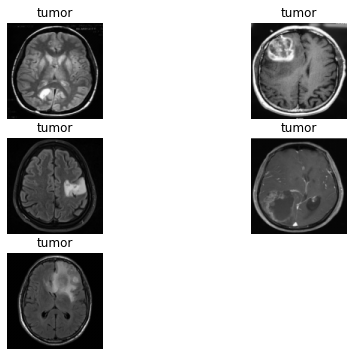

In [23]:
#plotting 5 correctly labeled images
plt.figure(figsize=(8,6))

for i in range(5):
  ax = plt.subplot(3,2, i + 1)
  plt.imshow(x_test[i])
  if y_pred[correct_idx[i]] == 1:
    title = "tumor"
  else :
    title = "non-tumor"

  plt.title(title)
  plt.axis("off")

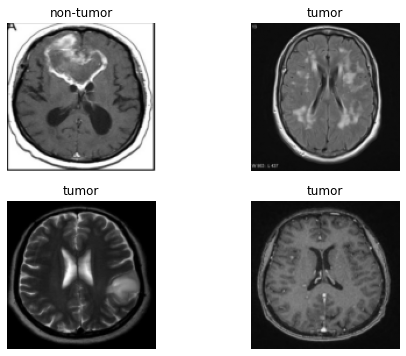

In [24]:
# plotting all the incorrectly labeled images
plt.figure(figsize=(8,6))
plt.title("Incorrect Labels")

l = len(incorrect_idx)
for i in range(l):
  ax = plt.subplot(np.ceil(l/2),np.floor(l/2), i + 1)
  plt.imshow(x_test[incorrect_idx[i]])
  if y_pred[incorrect_idx[i]] == 1:
    title = "tumor"
  else :
    title = "non-tumor"

  plt.title(title)
  plt.axis("off")

In [25]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [26]:
baseline_results = model.evaluate(x_test,y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.7439443469047546
accuracy :  0.995331883430481
precision :  0.9947356581687927
recall :  0.9976767897605896



Legitimate Transactions Detected (True Negatives):  17
Legitimate Transactions Incorrectly Detected (False Positives):  3
Fraudulent Transactions Missed (False Negatives):  1
Fraudulent Transactions Detected (True Positives):  30
Total Fraudulent Transactions:  31


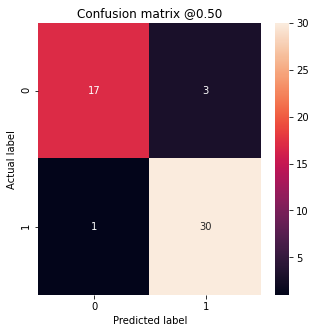

In [28]:
plot_cm(y_test, y_pred)

In [29]:
l = len(y_test)
acc = sum([y_pred[i]==y_test[i] for i in range(l)])/l
acc

array([0.92156863])